In [ ]:
from src.io_utils import load_data
import src.functions as F
import src.viz as V
from src.healthanalyzer import HealthAnalyzer

df = load_data("data/health_study_dataset.csv")

## Beskrivande analys

In [ ]:
# F.summary_data(df, ["age"])
# F.summary_data(df, ["height"])
# F.summary_data(df, ["weight"])
# F.summary_data(df, ["systolic_bp"])
# F.summary_data(df, ["cholesterol"])

display(df[["age", "height", "weight", "systolic_bp", "cholesterol"]].describe())

<Figure size 800x500 with 0 Axes>

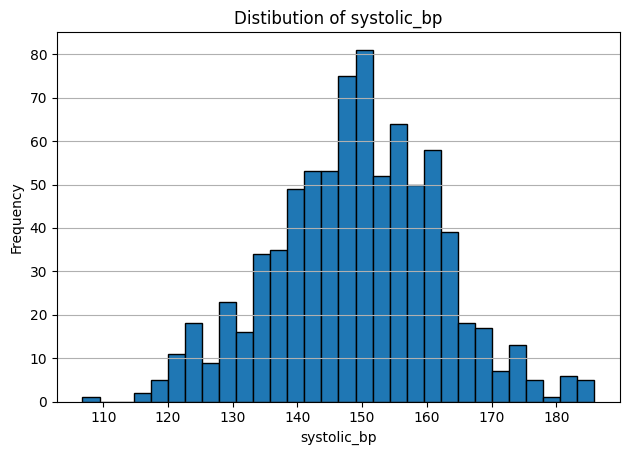

<Figure size 800x500 with 0 Axes>

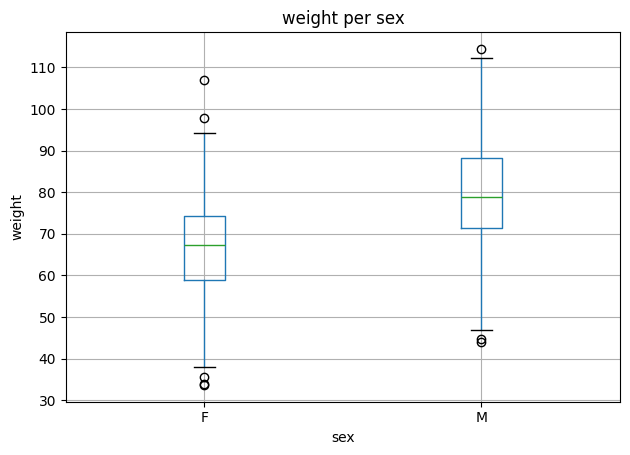

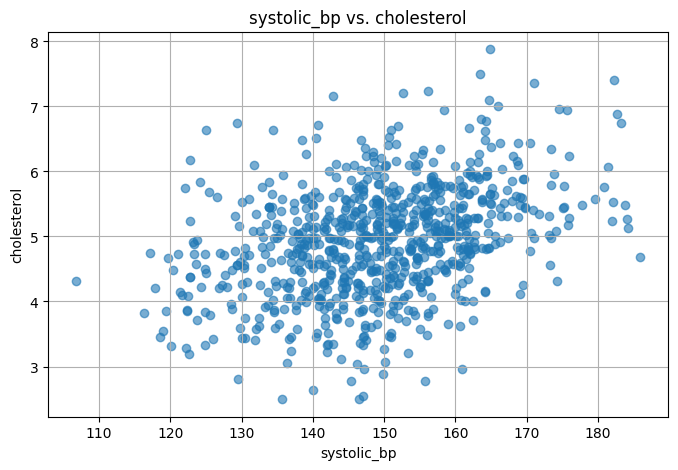

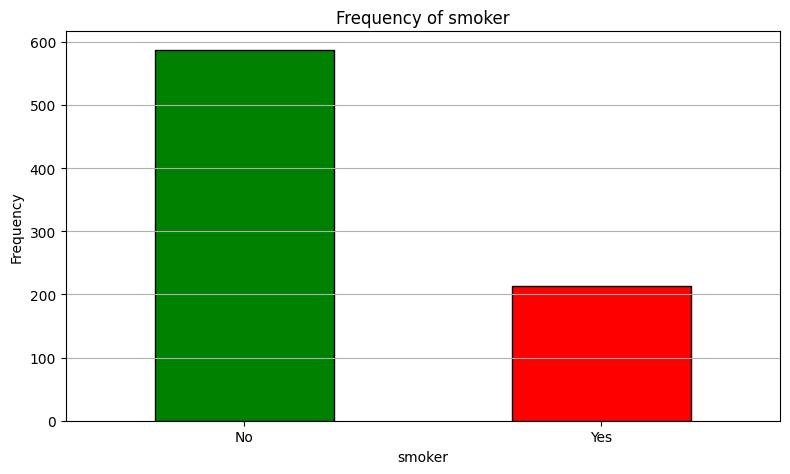

In [3]:
V.plot_hist(df, "systolic_bp")
V.plot_box_by_group(df, "weight", "sex")
V.plot_scatter(df, "systolic_bp", "cholesterol")
V.plot_bar_chart(df, "smoker")

## Simulering kopplat till caset

In [ ]:
F.simulating_proportions(df, ["disease"], 1000)

## Konfidensintervall för systoliskt blodtryck
- Valde att göra normalapproximation med hjälp av t-fördelning då populationsstandardavvikelse är okänd.
- Konfidensintervallet blir litet då vi har ett stort stickprov med litet spridning (liten standardavvikelse)
- Uträkning med bootstrap gav ett snävare intervall vilket kan tyda på mer precis uträkning men kan också bero på att bootstrapen underskattar osäkerheten. Normalapproximation är mer konservativ.
- Källa: Business Statistics av Jaggia & Kelly (2021)

In [ ]:
low, high = F.conf_intervall(df["systolic_bp"])
low_boot, high_boot = F. ci_mean_bootstrap(df["systolic_bp"])
mean_systolic_bp = df["systolic_bp"].mean()

print(f"Medelvärde för systoliskt bloodtryck: {mean_systolic_bp:.2f}")
print(f"95% CI med normalapproximation = ({low:.2f}, {high:.2f})")
print(f"95% CI med bootstrap = ({low_boot:.2f}, {high_boot:.2f})")


## Hypotesprövning
- HO: medelvärde för bloodtryck hos rökare = medelvärde för bloodtryck hos icke-rökare
- H1: medelvärde för bloodtryck hos rökare > medelvärde för bloodtryck hos icke-rökare

Vi gör ett ensidigt Welch's t-test då varianserna för våra två grupper inte kan antas lika (equal_var=False).
- Källa: Scipy docs: stats.ttest_ind

Vi räknar ut ett konfidensintervall för skillnaden i medelvärden med hjälp av t-fördelningen.
- Källa: Business Statistics av Jaggia & Kelly (2021)

### Slutsats 
- p-värdet > 0.05 vilket gör att vi inte kan förkasta nollhypotesen vid signifikansnivå 95%.
- Konfidensintervallet innehåller 0 vilket också visar att vi inte kan förkasta nollhypotesen
- Detta innebär att det inte finns tillräckligt statistikt stöd för att rökare har högre medelblodtryck än icke-rökare

In [ ]:
from statsmodels.stats.api import DescrStatsW
from statsmodels.stats.api import CompareMeans
from scipy import stats

bp_smoker = df[df["smoker"] == "Yes"]["systolic_bp"]
bp_no_smoker = df[df["smoker"] == "No"]["systolic_bp"]

t_stat, p_value = stats.ttest_ind(bp_smoker, bp_no_smoker, equal_var=False, alternative="greater")
res = CompareMeans(DescrStatsW(bp_smoker), DescrStatsW(bp_no_smoker))
low_ci_diff, high_ci_diff = res.tconfint_diff(alpha=0.05, usevar="unequal")

summary = f"""
Medelvärde på bloodtryck för rökare: {bp_smoker.mean():.3f}
Medelvärde på bloodtryck för icke-rökare: {bp_no_smoker.mean():.3f}
Differensen mellan medelvärdena: {bp_smoker.mean() - bp_no_smoker.mean():.3f}
Teststatistika = {t_stat:.3f} \np-värde = {p_value:.3f}
CI 95% för skillnaden i gruppernas medelvärden: {low_ci_diff:.3f}, {high_ci_diff:.3f}
"""
print(summary)

## Power

- Valde mellan NormalIndPower() och TTestIndPower(). Den senare används när varianserna är lika eller kan anses lika. Då vi inte har antagit lika varians tidigare väljs istället NormalIndPower() för att beräkna power baserat på normalapproximation. 

- NormIndPower() kan användas när vi har normalfördelad data eller tillräckligt stora stickprov där t-fördelningen nästan är lika med normalfördelningen. Vi har två stickprov med ca 200 respektive 550 observationer vilket kan anses som tillräckligt stora.

- Källa: Statsmodels docs: stats.power.TTestIndPower och stats.power.NormalIndPower
- Källa: Business Statistics av Jaggia & Kelly (2021)


### Slutsats
- Att power blir så lågt (0.074) innebär att sannolikheten att upptäcka verklig skillnad i blodtryck mellan rökare och icke-rökar är mycekt liten med det aktuella datamaterialet

In [ ]:
from statsmodels.stats.power import NormalIndPower

mean1 = bp_smoker.mean()
mean2 = bp_no_smoker.mean()
sd1, sd2 = bp_smoker.std(ddof=1), bp_no_smoker.std(ddof=1)
d_welch = (mean1 - mean2) / np.sqrt((sd1**2 + sd2**2) / 2)
alpha = 0.05
n_smoker = len(bp_smoker)
n_no_smoker = len(bp_no_smoker)
ratio = n_no_smoker / n_smoker

solver = NormalIndPower()

power = solver.power(effect_size=d_welch,
                                nobs1=n_smoker,
                                alpha=alpha,
                                ratio=ratio,
                                alternative="two-sided")


print(f"Power (normalapproximation) ≈ {power:.3f}")

In [ ]:
from sklearn.linear_model import LinearRegression
import numpy as np

x = df[["age"]].values
y = df["systolic_bp"].values

linreg = LinearRegression()
linreg.fit(x, y)

intercept_hat = float(linreg.intercept_)
slope_hat = float(linreg.coef_[0])
r2 = float(linreg.score(x, y))
y_hat = linreg.predict(x)
residuals = y - y_hat

ax = V.plot_scatter(df, "age", "systolic_bp")
x_line = np.linspace(df["age"].min(), df["age"].max(), 100)
y_line = intercept_hat + slope_hat * x_line
ax.plot(x_line, y_line, color="black", linewidth=2)

V.residual_plot(y_hat, residuals)

predicted_y_60 = F.regression_prediction(60, intercept_hat, slope_hat)

print(f"""
    Intercept: {intercept_hat:.2f}
    Slope: {slope_hat:.2f}
    R²: {r2:.3f}
    Predicted systolic BP at age 60 using our regression-model: {predicted_y_60:.1f}
""")


In [ ]:
analyzer = HealthAnalyzer(df)

analyzer.summary_data(["age"])